<a href="https://colab.research.google.com/github/noircode/ds-dojo/blob/main/Fraud_Detection_Car_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

Vehicle insurance fraud involves conspiracy to make a false claim involving excessive vehicle damage or motorist injury following an accident. Some common examples include staged accidents where the fraudster deliberately "sets" for the accident to occur; the use of shadow passengers where people who were not even at the scene of the accident claim to have suffered serious injuries, and making false personal injury claims where personal injuries are exaggerated. For that we will try to create an ML model to detect cases of fraud when claiming insurance and which are not cases of fraud (no fraud).

In [2]:
!pip install -q opendatasets

In [3]:
import opendatasets as od

In [ ]:
# fetch datasets
od.download("https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection")

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pickle
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')


In [6]:
pd.set_option('display.max_columns', None) # look for all columns

In [7]:
df = pd.read_csv("/content/vehicle-claim-fraud-detection/fraud_oracle.csv")

In [8]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [10]:
df.isna().sum().sum()

0

In [11]:
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


# Data Cleaning

Based on `describe()`, there are anomaly on `Age` Columns. Logically there are no such things as 0 age, so we can assume 0 value as a missing value. In order to do that, we are going to change zero values into NaN values.

In [12]:
df['Age'].replace(0, np.nan, inplace=True)

# EDA

In [13]:
df_eda = df.copy()

In [14]:
print(f"Numeric Columns: {df.select_dtypes(include=np.number).columns}")
print(f"\nCategory Columns: {df.select_dtypes(include='object').columns}")

Numeric Columns: Index(['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'FraudFound_P',
       'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year'],
      dtype='object')

Category Columns: Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')


In [15]:
df_eda['FraudFound_P'].value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

In [16]:
# replace 0 to "no fraud" and 1 to "fraud"
# for eda porposes
df_eda['FraudFound_P'].replace({0: 'no fraud', 1: 'fraud'}, inplace=True)

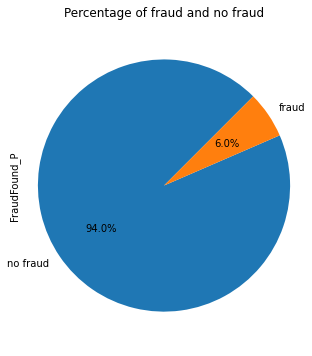

In [17]:
perc_tot_term_dep = df_eda['FraudFound_P'].value_counts(normalize=True)*100

perc_tot_term_dep.plot(kind='pie',
                       figsize=(5,6),
                       autopct='%1.1f%%',
                       startangle=45,
                       shadow=False)

plt.title('Percentage of fraud and no fraud')
plt.axis('equal')

plt.show()

We can tell that our target feature is imbalanced. There's only 6% of fraud and that's will effect our model later.

In [18]:
df_eda_fraud = df_eda[df_eda['FraudFound_P'] == 'fraud']

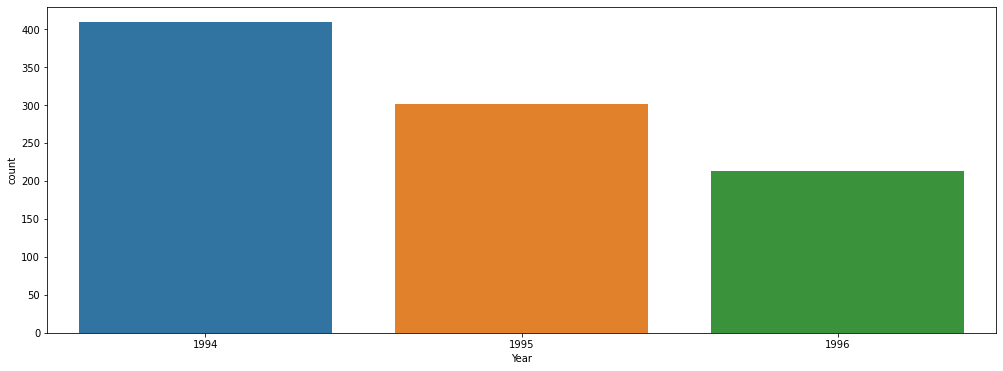

In [19]:
plt.figure(figsize=(17, 6))
sns.countplot('Year', data=df_eda_fraud)

In [20]:
df_eda_fraud.groupby("Year")["FraudFound_P"].value_counts()

Year  FraudFound_P
1994  fraud           409
1995  fraud           301
1996  fraud           213
Name: FraudFound_P, dtype: int64

Fraud cases decreased within 3 years (1994 - 1996).

External    919
Internal      4
Name: AgentType, dtype: int64


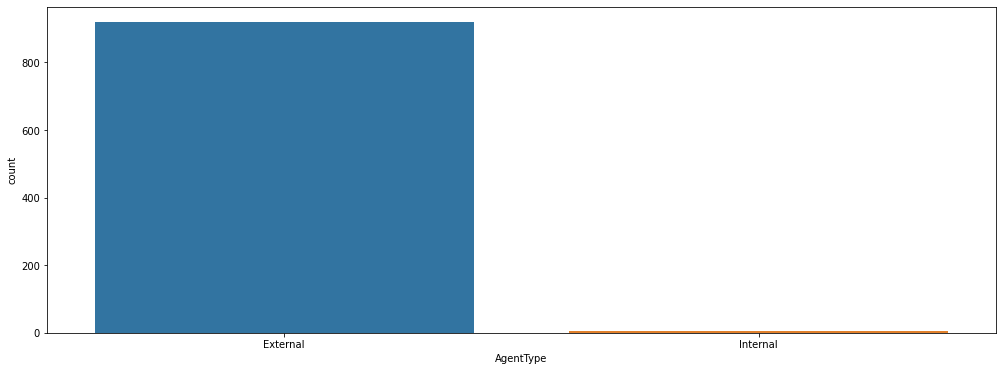

In [21]:
plt.figure(figsize=(17, 6))
sns.countplot(x="AgentType", data= df_eda_fraud)
print(df_eda_fraud['AgentType'].value_counts())

Fraud is mostly done by clients who use agents from external companies. This happen because external agents is not bound to any companies.

Text(0.5, 1.0, 'Vehicle Price on Fraud Case')

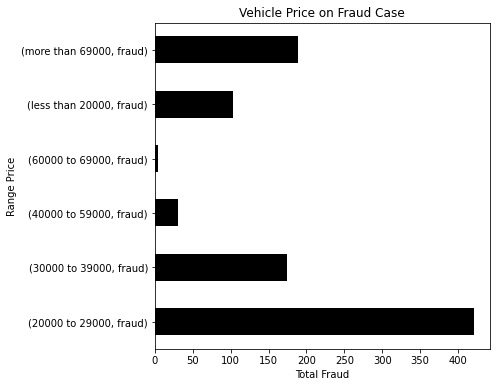

In [22]:
range_price = df_eda_fraud.groupby("VehiclePrice")["FraudFound_P"].value_counts()
range_price.plot(kind='barh', figsize=(6,6), color='black')
plt.xlabel('Total Fraud')
plt.ylabel('Range Price')
plt.title('Vehicle Price on Fraud Case')

Fraud is mostly happend on vehicle that have price range between 20000-29000 with more than 400 cases

# Data Preprocessing

## Get Data Inference

In [23]:
df_inf = df.sample(30, random_state=42)
df_train_test = df.drop(df_inf.index)

In [24]:
df_inf.reset_index(drop=True, inplace=True)
df_train_test.reset_index(drop=True, inplace=True)

## Split the Data

In [25]:
X = df_train_test.drop(['FraudFound_P'], axis=1)
y = df_train_test['FraudFound_P']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)

(12312, 32)
(3078, 32)


## Outliers Handling

In [27]:
X_train_distr = pd.DataFrame({'columns':X_train.describe().columns, 'skew': X_train.skew(axis=0)})
X_train_distr.reset_index(drop=True, inplace=True)
X_train_distr['distribution'] = np.where((X_train_distr['skew'] < 0.5) & (X_train_distr['skew'] > -0.5), "Normal", "Skew")
X_train_distr

,columns,skew,distribution
0,WeekOfMonth,0.113659,Normal
1,WeekOfMonthClaimed,0.149548,Normal
2,Age,0.715352,Skew
3,PolicyNumber,0.006882,Normal
4,RepNumber,0.011597,Normal
5,Deductible,6.020236,Skew
6,DriverRating,0.007453,Normal
7,Year,0.255512,Normal


There are 2 columns that have skew distribution:
- Age is right skewed
- Deductible also right skewed

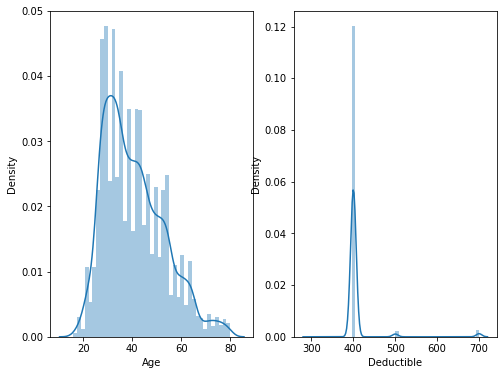

In [28]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
sns.distplot(X_train['Age'], ax=ax[0])
sns.distplot(X_train['Deductible'], ax=ax[1])

In [29]:
def find_normal_boundaries(df, variable):
  upper_boundary = df[variable].mean() + 3 * df[variable].std()
  lower_boundary = df[variable].mean() - 3 * df[variable].std()
  return upper_boundary, lower_boundary

def find_skewed_boundaries(df, variable, distance):
  IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

  lower = df[variable].quantile(0.25) - distance * IQR
  upper = df[variable].quantile(0.75) + distance * IQR
  return upper, lower

In [30]:
X_train_distr

,columns,skew,distribution
0,WeekOfMonth,0.113659,Normal
1,WeekOfMonthClaimed,0.149548,Normal
2,Age,0.715352,Skew
3,PolicyNumber,0.006882,Normal
4,RepNumber,0.011597,Normal
5,Deductible,6.020236,Skew
6,DriverRating,0.007453,Normal
7,Year,0.255512,Normal


In [31]:
j = 0
outliers = {}
for i in X_train.describe().columns:
  if X_train_distr['distribution'].loc[(X_train_distr['columns']==i)].values[0] == 'Normal':
    upper_boundary, lower_boundary = find_normal_boundaries(X_train, i)
    print(f"Boundary Lower dan Upper {i}: {lower_boundary, upper_boundary}")
    outliers[f"outliers{j}"] = np.where(X_train[i] > upper_boundary, True, np.where(X_train[i] < lower_boundary, True, False))
  else:
    upper_boundary, lower_boundary = find_skewed_boundaries(X_train, i, 1.5)
    print(f"Batas lower dan upper untuk {i}:{lower_boundary, upper_boundary}")
    outliers[f"outliers{j}"] = np.where(X_train[i] > upper_boundary, True, np.where(X_train[i] < lower_boundary, True, False))
  print("="*30)
  j+= 1

Boundary Lower dan Upper WeekOfMonth: (-1.0579133211356835, 6.642546199628211)
Boundary Lower dan Upper WeekOfMonthClaimed: (-1.06743303626692, 6.461682548937485)
Batas lower dan upper untuk Age:(4.0, 76.0)
Boundary Lower dan Upper PolicyNumber: (-5671.387008329399, 21041.613454073387)
Boundary Lower dan Upper RepNumber: (-5.331157002274647, 22.218259016569643)
Batas lower dan upper untuk Deductible:(400.0, 400.0)
Boundary Lower dan Upper DriverRating: (-0.8716744681675266, 5.850881745620418)
Boundary Lower dan Upper Year: (1992.4524538766675, 1997.2700932318446)


In order to handling outliers, we are going to make some rules like:

- If outliers is between 0 - 5%, we are going to use trimming

- If outliers is between 5 - 15%, we are going to use capping/windsorizer

In [32]:
for i, (k,v) in enumerate(outliers.items()):
  X_train_distr_handling = X_train.loc[~outliers[k]]
  X_train_distr.loc[i, 'trimmed_row'] = X_train.shape[0] - X_train_distr_handling.shape[0]
  X_train_distr.loc[i, 'percentage'] = np.round(100-(X_train_distr_handling.shape[0]/X_train.shape[0]*100), 2)
  X_train_distr.loc[i, 'action'] = np.where(X_train_distr.loc[i, 'percentage']==0, 'No Action',
                                    np.where(X_train_distr.loc[i, 'percentage'] > 15, 'Capping/Windsorizer', 'Trimming'))

In [33]:
X_train_distr

,columns,skew,distribution,trimmed_row,percentage,action
0,WeekOfMonth,0.113659,Normal,0.0,0.00,No Action
1,WeekOfMonthClaimed,0.149548,Normal,0.0,0.00,No Action
2,Age,0.715352,Skew,90.0,0.73,Trimming
3,PolicyNumber,0.006882,Normal,0.0,0.00,No Action
4,RepNumber,0.011597,Normal,0.0,0.00,No Action
5,Deductible,6.020236,Skew,479.0,3.89,Trimming
6,DriverRating,0.007453,Normal,0.0,0.00,No Action
7,Year,0.255512,Normal,0.0,0.00,No Action


In [34]:
outliers_tot = outliers['outliers2']

for i, (k,v) in enumerate(outliers.items()):
  if i in [2,5]: # Age, Deductible
    outliers_tot += outliers[k]

In [35]:
X_train_trimmed = X_train.loc[~outliers_tot]
y_train_trimmed = y_train.loc[~outliers_tot]

print(f"Total rows in X_train BEFORE trimmed: {X_train.shape[0]}")
print(f"Total rows in X_train AFTER trimmed: {X_train_trimmed.shape[0]}")
print(f"% Outliers on the dataset: {100-(X_train_trimmed.shape[0]/X_train.shape[0]*100):.2f}%")

Total rows in X_train BEFORE trimmed: 12312
Total rows in X_train AFTER trimmed: 11747
% Outliers on the dataset: 4.59%


In [36]:
def diagnostic_plot(df, variable, figsize=(16,4)):
  plt.figure(figsize=figsize)

  # Histogram
  plt.subplot(1,2,1)
  sns.histplot(df[variable], bins=30)
  plt.title("Histogram")

  # Boxplot
  plt.subplot(1,2,2)
  sns.boxplot(y=df[variable])
  plt.title('Boxplot')

  plt.show()

Age - Before Trimming


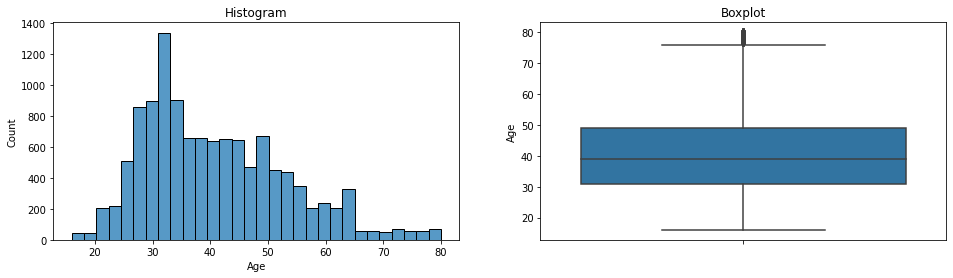


Age - After Trimming


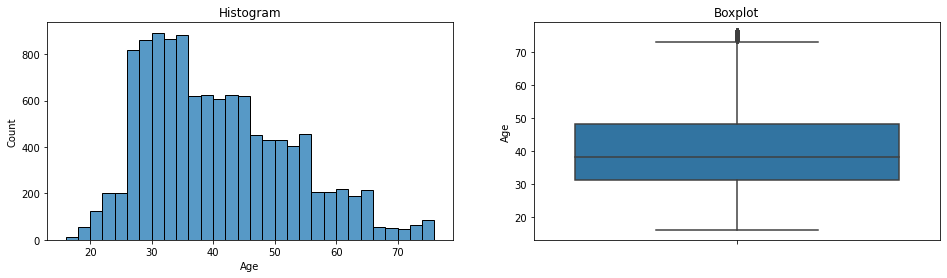

Deductible - Before Trimming


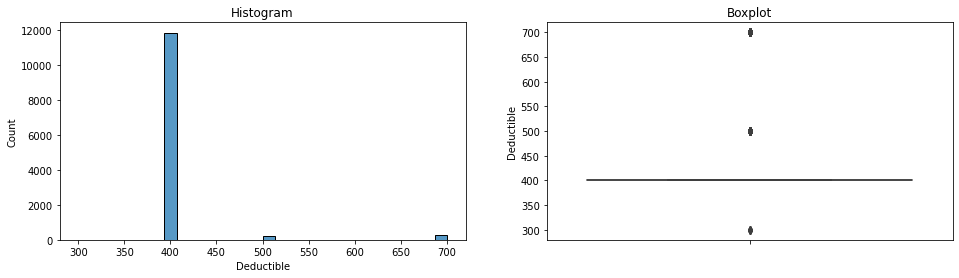


Deductible - After Trimming


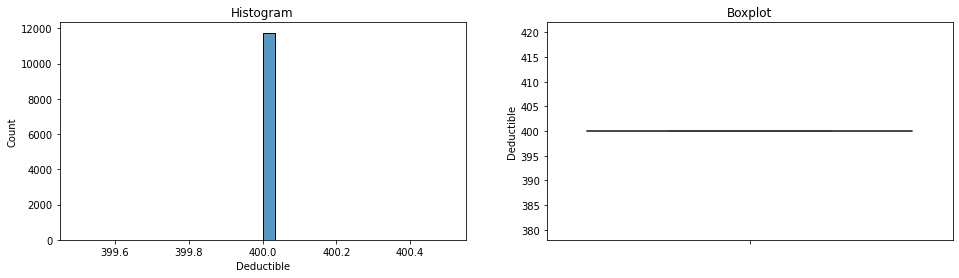

In [37]:
for col in ['Age', 'Deductible']:
  print(f"{col} - Before Trimming")
  diagnostic_plot(X_train, col)
  print(f"\n{col} - After Trimming")
  diagnostic_plot(X_train_trimmed, col)

## Missing Value Handling

In [38]:
X_train_trimmed.isna().sum()

Month                     0
WeekOfMonth               0
DayOfWeek                 0
Make                      0
AccidentArea              0
DayOfWeekClaimed          0
MonthClaimed              0
WeekOfMonthClaimed        0
Sex                       0
MaritalStatus             0
Age                     243
Fault                     0
PolicyType                0
VehicleCategory           0
VehiclePrice              0
PolicyNumber              0
RepNumber                 0
Deductible                0
DriverRating              0
Days_Policy_Accident      0
Days_Policy_Claim         0
PastNumberOfClaims        0
AgeOfVehicle              0
AgeOfPolicyHolder         0
PoliceReportFiled         0
WitnessPresent            0
AgentType                 0
NumberOfSuppliments       0
AddressChange_Claim       0
NumberOfCars              0
Year                      0
BasePolicy                0
dtype: int64

In [39]:
X_train_trimmed['Age'].skew()

0.6357315051693005

In [40]:
X_test.isna().sum()

Month                    0
WeekOfMonth              0
DayOfWeek                0
Make                     0
AccidentArea             0
DayOfWeekClaimed         0
MonthClaimed             0
WeekOfMonthClaimed       0
Sex                      0
MaritalStatus            0
Age                     76
Fault                    0
PolicyType               0
VehicleCategory          0
VehiclePrice             0
PolicyNumber             0
RepNumber                0
Deductible               0
DriverRating             0
Days_Policy_Accident     0
Days_Policy_Claim        0
PastNumberOfClaims       0
AgeOfVehicle             0
AgeOfPolicyHolder        0
PoliceReportFiled        0
WitnessPresent           0
AgentType                0
NumberOfSuppliments      0
AddressChange_Claim      0
NumberOfCars             0
Year                     0
BasePolicy               0
dtype: int64

We can fill the missing value of Age columns with its median.

In [41]:
X_train_trimmed['Age'].fillna(X_train_trimmed['Age'].median(), inplace=True)
X_test['Age'].fillna(X_train_trimmed['Age'].median(), inplace=True)

## Feature Selection

In [42]:
df_eda.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21.0,Policy Holder,Sport - Liability,Sport,more than 69000,no fraud,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34.0,Policy Holder,Sport - Collision,Sport,more than 69000,no fraud,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47.0,Policy Holder,Sport - Collision,Sport,more than 69000,no fraud,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65.0,Third Party,Sedan - Liability,Sport,20000 to 29000,no fraud,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27.0,Third Party,Sport - Collision,Sport,more than 69000,no fraud,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


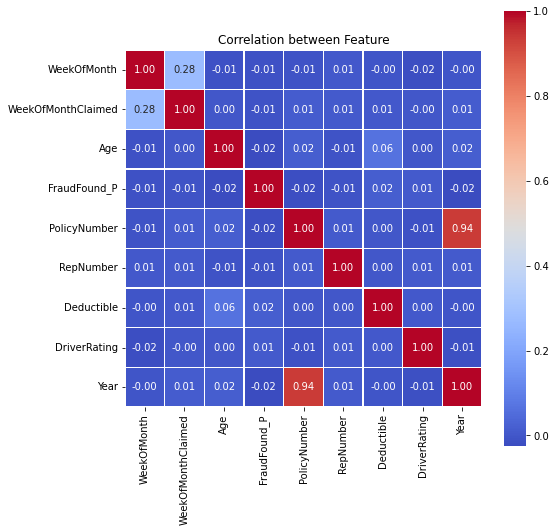

In [43]:
plt.figure(figsize=(8,8))

sns.heatmap(df.corr(), fmt=".2f", square=True, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title("Correlation between Feature")
plt.show()

In [44]:
X_train_trimmed.drop(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed','MonthClaimed', 'WeekOfMonthClaimed', 'PolicyNumber','RepNumber' ,'Year'], axis=1, inplace=True)
X_test.drop(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed','MonthClaimed', 'WeekOfMonthClaimed', 'PolicyNumber','RepNumber' ,'Year'], axis=1, inplace=True)

The Deleted columns is based on the correlation between feature and target columns. However, some category columns were deleted because based on information from datasets sources, some category columns didn't have a clear enough explanation.

## Splitting Columns(Numerical and Categorical Columns)

In [45]:
num_columns = X_train_trimmed.select_dtypes(include=np.number).columns
cat_columns = X_train_trimmed.select_dtypes(include=['object']).columns

print('Numeric Columns:', list(num_columns))
print('Categorical Columns:', list(cat_columns))

Numeric Columns: ['Age', 'Deductible', 'DriverRating']
Categorical Columns: ['Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']


In [46]:
# Split on X_train
X_train_trimmed_num = X_train_trimmed[num_columns]
X_train_trimmed_cat = X_train_trimmed[cat_columns]

# Split on X_test
X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]
X_test_cat = X_test_cat[X_test_cat['PolicyType'] != "Sport - Liability"][:]

In [47]:
# Scalling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_trimmed_num_scaled = scaler.fit_transform(X_train_trimmed_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [48]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_train_trimmed_cat_encoded = encoder.fit_transform(X_train_trimmed_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

## Concatenate between numerical columns and categorical columns

In [49]:
X_train_final = np.concatenate([X_train_trimmed_num_scaled,X_train_trimmed_cat_encoded.toarray()], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded.toarray()], axis=1)

## Model Definition, Training, Evaluation

### Logistic Regression

In [50]:
# Without Tuning

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_final, y_train_trimmed)

y_pred_train_logreg = logreg.predict(X_train_final)
y_pred_test_logreg = logreg.predict(X_test_final)

print('Train:\n')
print(classification_report(y_train_trimmed, y_pred_train_logreg))
print(confusion_matrix(y_train_trimmed, y_pred_train_logreg))
print('\nTest:\n')
print(classification_report(y_test, y_pred_test_logreg))
print(confusion_matrix(y_test, y_pred_test_logreg))

Train:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11075
           1       1.00      0.01      0.02       672

    accuracy                           0.94     11747
   macro avg       0.97      0.50      0.49     11747
weighted avg       0.95      0.94      0.92     11747

[[11075     0]
 [  666     6]]

Test:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.00      0.00      0.00       184

    accuracy                           0.94      3078
   macro avg       0.47      0.50      0.48      3078
weighted avg       0.88      0.94      0.91      3078

[[2894    0]
 [ 184    0]]


In [51]:
# Logreg Tunning

log_reg_params = {
    'penalty':['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'class_weight':['balanced']
}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=5, verbose=1, n_jobs=-1)
grid_log_reg.fit(X_train_final, y_train_trimmed)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs']},
             verbose=1)

In [52]:
grid_log_reg_best = grid_log_reg.best_estimator_
grid_log_reg_best

LogisticRegression(C=0.001, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [53]:
y_train_pred_grid_log_reg = grid_log_reg_best.predict(X_train_final)
y_test_pred_grid_log_reg = grid_log_reg_best.predict(X_test_final)

print(f"{'-'*21}TRAIN{'-'*21}")
print(classification_report(y_train_trimmed, y_train_pred_grid_log_reg))
print(confusion_matrix(y_train_trimmed, y_train_pred_grid_log_reg))
print(f"{'-'*21}TEST{'-'*21}")
print(classification_report(y_test, y_test_pred_grid_log_reg))
print(confusion_matrix(y_test, y_test_pred_grid_log_reg))

---------------------TRAIN---------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11075
           1       0.00      0.00      0.00       672

    accuracy                           0.94     11747
   macro avg       0.47      0.50      0.49     11747
weighted avg       0.89      0.94      0.92     11747

[[11075     0]
 [  672     0]]
---------------------TEST---------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.00      0.00      0.00       184

    accuracy                           0.94      3078
   macro avg       0.47      0.50      0.48      3078
weighted avg       0.88      0.94      0.91      3078

[[2894    0]
 [ 184    0]]


## Decision Tree Classifier

In [54]:
# No Tunning
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_final, y_train_trimmed)

DecisionTreeClassifier(random_state=42)

In [55]:
y_pred_train_tree_clf = tree_clf.predict(X_train_final)
y_pred_test_tree_clf = tree_clf.predict(X_test_final)

print('-'*28 + 'TRAIN' + '-'*28)
print(classification_report(y_train_trimmed, y_pred_train_tree_clf))
print(confusion_matrix(y_train_trimmed, y_pred_train_tree_clf))
print('-'*28 + 'TRAIN' + '-'*28)
print(classification_report(y_test, y_pred_test_tree_clf))
print(confusion_matrix(y_test, y_pred_test_tree_clf))

----------------------------TRAIN----------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11075
           1       1.00      0.92      0.96       672

    accuracy                           1.00     11747
   macro avg       1.00      0.96      0.98     11747
weighted avg       1.00      1.00      1.00     11747

[[11075     0]
 [   57   615]]
----------------------------TRAIN----------------------------
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2894
           1       0.15      0.17      0.16       184

    accuracy                           0.89      3078
   macro avg       0.55      0.55      0.55      3078
weighted avg       0.90      0.89      0.89      3078

[[2712  182]
 [ 153   31]]


In [56]:
# Tuning
params_tree_clf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2,10),
    'min_samples_split': np.arange(2,10),
    'min_samples_leaf': np.arange(2,10)
}

tree_clf_grid = GridSearchCV(DecisionTreeClassifier(), params_tree_clf,
                             n_jobs=-1, verbose=1, cv=5)
tree_clf_grid.fit(X_train_final, y_train_trimmed)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
             verbose=1)

In [57]:
tree_clf_grid_best = tree_clf_grid.best_estimator_
tree_clf_grid_best

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)

In [58]:
y_pred_train_tree_clf_grid = tree_clf_grid_best.predict(X_train_final)
y_pred_test_tree_clf_grid = tree_clf_grid_best.predict(X_test_final)

print('-'*28 + "TRAIN" + '-'*28)
print(classification_report(y_train_trimmed, y_pred_train_tree_clf_grid))
print(confusion_matrix(y_train_trimmed, y_pred_train_tree_clf_grid))
print('-'*28 + "TEST" + '-'*28)
print(classification_report(y_test, y_pred_test_tree_clf_grid))
print(confusion_matrix(y_test, y_pred_test_tree_clf_grid))

----------------------------TRAIN----------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11075
           1       0.00      0.00      0.00       672

    accuracy                           0.94     11747
   macro avg       0.47      0.50      0.49     11747
weighted avg       0.89      0.94      0.92     11747

[[11075     0]
 [  672     0]]
----------------------------TEST----------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.00      0.00      0.00       184

    accuracy                           0.94      3078
   macro avg       0.47      0.50      0.48      3078
weighted avg       0.88      0.94      0.91      3078

[[2894    0]
 [ 184    0]]


## KNN

In [59]:
# No Tunning
knn = KNeighborsClassifier()
knn.fit(X_train_final, y_train_trimmed)

KNeighborsClassifier()

In [60]:
y_pred_train_knn = knn.predict(X_train_final)
y_pred_test_knn = knn.predict(X_test_final)

print('-'*28 + 'TRAIN' + '-'*28)
print(classification_report(y_train_trimmed, y_pred_train_knn))
print(confusion_matrix(y_train_trimmed, y_pred_train_knn))
print('-'*28 + 'TEST' + '-'*28)
print(classification_report(y_test, y_pred_test_knn))
print(confusion_matrix(y_test, y_pred_test_knn))

----------------------------TRAIN----------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11075
           1       0.59      0.08      0.15       672

    accuracy                           0.94     11747
   macro avg       0.77      0.54      0.56     11747
weighted avg       0.93      0.94      0.92     11747

[[11035    40]
 [  615    57]]
----------------------------TEST----------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2894
           1       0.17      0.02      0.04       184

    accuracy                           0.94      3078
   macro avg       0.55      0.51      0.50      3078
weighted avg       0.89      0.94      0.91      3078

[[2874   20]
 [ 180    4]]


In [61]:
# Tuning
params_knn = {
    'n_neighbors': np.arange(2,7),
    'weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), params_knn, n_jobs=-1,
                        cv=5, verbose=2)
knn_grid.fit(X_train_final, y_train_trimmed)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6]),
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [62]:
y_pred_train_knn_grid = knn_grid.predict(X_train_final)
y_pred_test_knn_grid = knn_grid.predict(X_test_final)

print('-'*28 + 'TRAIN' + '-'*28)
print(classification_report(y_train_trimmed, y_pred_train_knn_grid))
print(confusion_matrix(y_train_trimmed, y_pred_train_knn_grid))
print(f"TRAIN ACCURACY: {100*round(accuracy_score(y_train_trimmed, y_pred_train_knn_grid),4)}%")
print('-'*28 + 'TEST' + '-'*28)
print(classification_report(y_test, y_pred_test_knn_grid))
print(confusion_matrix(y_test, y_pred_test_knn_grid))
print(f"TEST ACCURACY: {100*round(accuracy_score(y_test, y_pred_test_knn_grid), 4)}%")

----------------------------TRAIN----------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11075
           1       0.76      0.02      0.04       672

    accuracy                           0.94     11747
   macro avg       0.85      0.51      0.50     11747
weighted avg       0.93      0.94      0.92     11747

[[11071     4]
 [  659    13]]
TRAIN ACCURACY: 94.36%
----------------------------TEST----------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.25      0.01      0.01       184

    accuracy                           0.94      3078
   macro avg       0.60      0.50      0.49      3078
weighted avg       0.90      0.94      0.91      3078

[[2891    3]
 [ 183    1]]
TEST ACCURACY: 93.96%


## Random Forest

In [63]:
# No Tunning
rnf_clf = RandomForestClassifier(random_state=42)
rnf_clf.fit(X_train_final, y_train_trimmed)

RandomForestClassifier(random_state=42)

In [64]:
y_pred_train_rnf_clf = rnf_clf.predict(X_train_final)
y_pred_test_rnf_clf = rnf_clf.predict(X_test_final)

print('-'*28 + 'TRAIN' + '-'*28)
print(classification_report(y_train_trimmed, y_pred_train_rnf_clf))
print(confusion_matrix(y_train_trimmed, y_pred_train_rnf_clf))
print(f'TRAIN ACCURACY: {100*round(accuracy_score(y_train_trimmed, y_pred_train_rnf_clf), 4)}')
print('-'*28 + 'TEST' + '-'*28)
print(classification_report(y_test, y_pred_test_rnf_clf))
print(confusion_matrix(y_test, y_pred_test_rnf_clf))
print(f'TEST ACCURACY: {100*round(accuracy_score(y_test, y_pred_test_rnf_clf), 4)}')

----------------------------TRAIN----------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11075
           1       1.00      0.92      0.96       672

    accuracy                           1.00     11747
   macro avg       1.00      0.96      0.98     11747
weighted avg       1.00      1.00      0.99     11747

[[11073     2]
 [   56   616]]
TRAIN ACCURACY: 99.51
----------------------------TEST----------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2894
           1       0.19      0.04      0.06       184

    accuracy                           0.93      3078
   macro avg       0.57      0.51      0.51      3078
weighted avg       0.90      0.93      0.91      3078

[[2865   29]
 [ 177    7]]
TEST ACCURACY: 93.31


In [65]:
# Tunning

rnf_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': np.arange(2,9,2),
    'max_depth': np.arange(2,5),
    'max_features': ['auto', 'sqrt', 'log2']
}

rnf_clf_grid = GridSearchCV(RandomForestClassifier(), rnf_params, n_jobs=-1,
                            verbose=2, cv=5)
rnf_clf_grid.fit(X_train_final, y_train_trimmed)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': array([2, 4, 6, 8])},
             verbose=2)

In [66]:
y_pred_train_rnf_clf_grid = rnf_clf_grid.predict(X_train_final)
y_pred_test_rnf_clf_grid = rnf_clf_grid.predict(X_test_final)

print('-'*28 + 'TRAIN' + '-'*28)
print(classification_report(y_train_trimmed, y_pred_train_rnf_clf_grid))
print(confusion_matrix(y_train_trimmed, y_pred_train_rnf_clf_grid))
print(f'TRAIN ACCURACY: {100*round(accuracy_score(y_train_trimmed, y_pred_train_rnf_clf_grid), 4)}')
print('-'*28 + 'TEST' + '-'*28)
print(classification_report(y_test, y_pred_test_rnf_clf_grid))
print(confusion_matrix(y_test, y_pred_test_rnf_clf_grid))
print(f'TEST ACCURACY: {100*round(accuracy_score(y_test, y_pred_test_rnf_clf_grid), 4)}')


----------------------------TRAIN----------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11075
           1       0.00      0.00      0.00       672

    accuracy                           0.94     11747
   macro avg       0.47      0.50      0.49     11747
weighted avg       0.89      0.94      0.92     11747

[[11075     0]
 [  672     0]]
TRAIN ACCURACY: 94.28
----------------------------TEST----------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.00      0.00      0.00       184

    accuracy                           0.94      3078
   macro avg       0.47      0.50      0.48      3078
weighted avg       0.88      0.94      0.91      3078

[[2894    0]
 [ 184    0]]
TEST ACCURACY: 94.02000000000001


Text(0.5, 1.0, 'Test Random Forest Tuning')

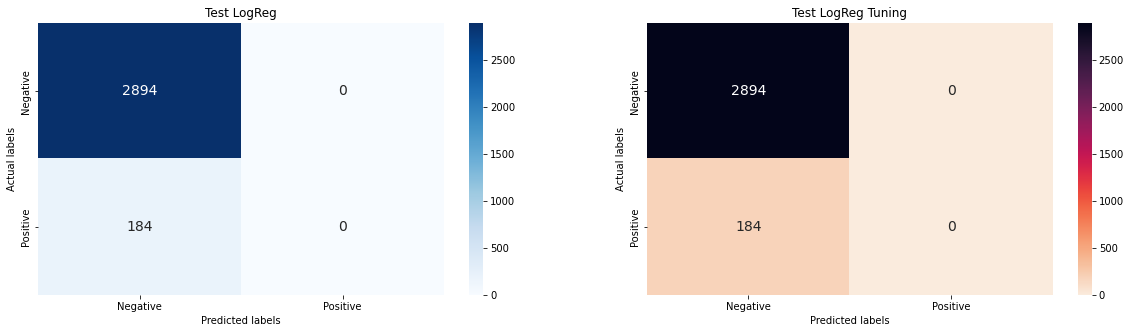

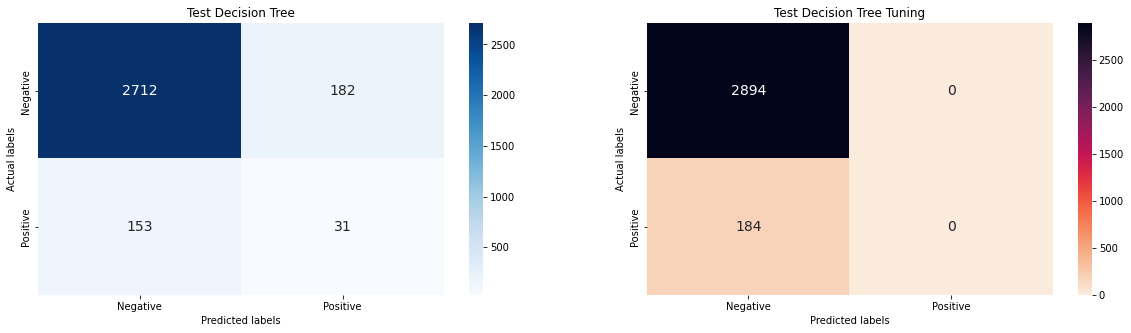

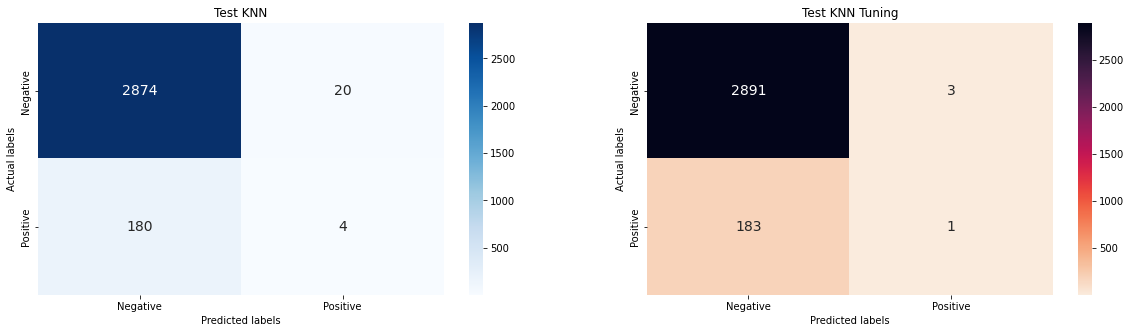

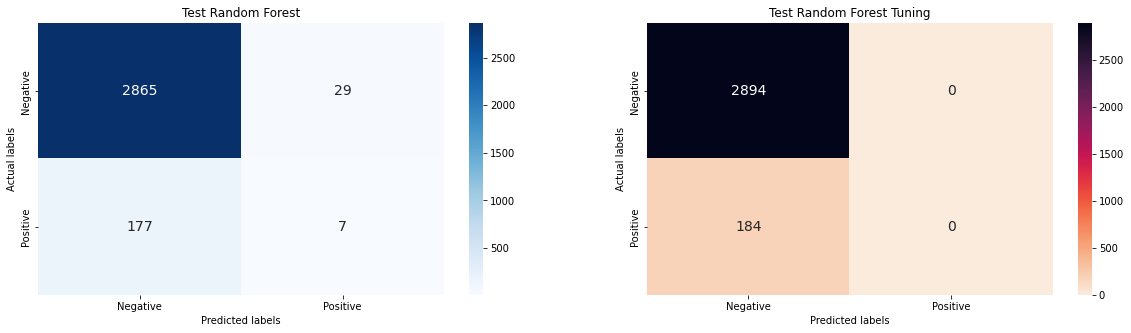

In [67]:
#plotting confusion matrix
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
logreg_matrix1= confusion_matrix(y_test, y_pred_test_logreg)
ax = sns.heatmap(logreg_matrix1, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test LogReg")

plt.subplot(1,2,2)
logreg_matrix2= confusion_matrix(y_test, y_test_pred_grid_log_reg)
ax = sns.heatmap(logreg_matrix2, annot=True, cmap='rocket_r', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test LogReg Tuning")


plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
tree_clf_matrix1= confusion_matrix(y_test, y_pred_test_tree_clf)
ax = sns.heatmap(tree_clf_matrix1, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test Decision Tree")

plt.subplot(1,2,2)
tree_clf_matrix2= confusion_matrix(y_test, y_pred_test_tree_clf_grid)
ax = sns.heatmap(tree_clf_matrix2, annot=True, cmap='rocket_r', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test Decision Tree Tuning")

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
neigh_matrix1= confusion_matrix(y_test, y_pred_test_knn)
ax = sns.heatmap(neigh_matrix1, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test KNN")

plt.subplot(1,2,2)
neigh_matrix2= confusion_matrix(y_test, y_pred_test_knn_grid)
ax = sns.heatmap(neigh_matrix2, annot=True, cmap='rocket_r', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test KNN Tuning")

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for_clf_matrix1= confusion_matrix(y_test, y_pred_test_rnf_clf)
ax = sns.heatmap(for_clf_matrix1, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test Random Forest")

plt.subplot(1,2,2)
for_clf_matrix2= confusion_matrix(y_test, y_pred_test_rnf_clf_grid)
ax = sns.heatmap(for_clf_matrix2, annot=True, cmap='rocket_r', fmt='g', annot_kws={"fontsize":14})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.title("Test Random Forest Tuning")

- Each model have almost the same performance and same biases due to imbalanced target class.

- Let's see if oversampling is going to make our model performance better.

## Oversampling

In [68]:
oversampler = SMOTE(random_state=42, n_jobs=-1)
X_train_final_smote, y_train_trimmed_smote = oversampler.fit_resample(X_train_final, y_train_trimmed)

In [71]:
MODELS = [LogisticRegression(), DecisionTreeClassifier(),
          KNeighborsClassifier(), RandomForestClassifier()]

for model in MODELS:
  clf = model.fit(X_train_final_smote, y_train_trimmed_smote)
  y_pred = clf.predict(X_test_final)

  print(f"Model: {str(clf.__class__).split('.')[-1]}:\n")
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  print(f"Test Accuracy: {100*round(accuracy_score(y_test, y_pred),2)}%")  

Model: LogisticRegression'>:

              precision    recall  f1-score   support

           0       0.99      0.62      0.77      2894
           1       0.13      0.91      0.23       184

    accuracy                           0.64      3078
   macro avg       0.56      0.77      0.50      3078
weighted avg       0.94      0.64      0.73      3078

[[1806 1088]
 [  17  167]]
Test Accuracy: 64.0%
Model: DecisionTreeClassifier'>:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2894
           1       0.17      0.21      0.19       184

    accuracy                           0.89      3078
   macro avg       0.56      0.57      0.56      3078
weighted avg       0.90      0.89      0.90      3078

[[2707  187]
 [ 146   38]]
Test Accuracy: 89.0%
Model: KNeighborsClassifier'>:

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      2894
           1       0.13      0.48      0.20  

- With oversampling(`SMOTE`) technique, we can clear model from biased classification, however the performance is too poor. The Precision score for `Fraud` cases is very low (lower than 14%). And  the Model is perform better without oversampling techinique .

- That's mean using Machine Learning model to predict Fraud on Car Insurance is not possible due to poor performance.

- If we can get the new data with more balanced target classes, there is probably a chance that we can predict Fraud with Machine Learning.

- And the best performance of all models above is Decision Tree Classifier with precision score of 94% `Not Fraud`, 19% `Fraud` and 93.31% Accuracy Score.

# Pipeline

In [83]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

data_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_columns),
    ('pipe_cat', cat_pipeline, cat_columns)
])

pipe_rnf_clf = make_pipeline(data_pipeline, rnf_clf)

In [87]:
pipe_rnf_clf.fit(X_train_trimmed, y_train_trimmed)

y_pred_test_pipe_rnf_clf = pipe_rnf_clf.predict(X_test)

print('-'*28 + 'TEST' + '-'*28)
print(classification_report(y_test, y_pred_test_pipe_rnf_clf))
print(confusion_matrix(y_test, y_pred_test_pipe_rnf_clf))
print(f'TEST ACCURACY: {100*round(accuracy_score(y_test, y_pred_test_pipe_rnf_clf),4)}%')

----------------------------TEST----------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2894
           1       0.19      0.04      0.06       184

    accuracy                           0.93      3078
   macro avg       0.57      0.51      0.51      3078
weighted avg       0.90      0.93      0.91      3078

[[2865   29]
 [ 177    7]]
TEST ACCURACY: 93.31%


In [88]:
# Model Saving
with open('rnf_pipe.pkl', 'wb') as f:
  pickle.dump(pipe_rnf_clf, f)

## Model Inference

In [89]:
df_inf.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [92]:
print(os.listdir())
PICKLE_MODEL = 'rnf_pipe.pkl'

with open(PICKLE_MODEL, 'rb') as f:
  model_pipeline = pickle.load(f)

['.config', 'rnf_pipe.pkl', 'vehicle-claim-fraud-detection', 'sample_data']


In [97]:
y_pred_inf = model_pipeline.predict(df_inf)
y_pred_inf = pd.DataFrame(y_pred_inf, columns=['Predicted_FraudFound_P'])

In [98]:
# Concatenate with Original Dataframe
df_inf_result = pd.concat([df_inf, y_pred_inf], axis=1)

In [99]:
df_inf_result.loc[:, ['AccidentArea', 'DriverRating', 'FraudFound_P', 'Predicted_FraudFound_P']]

,AccidentArea,DriverRating,FraudFound_P,Predicted_FraudFound_P
0,Urban,1,0,0
1,Urban,2,0,0
2,Urban,3,0,0
3,Urban,4,0,0
4,Urban,1,0,0
5,Urban,4,0,0
6,Urban,3,0,0
7,Urban,2,0,0
8,Urban,4,0,0
9,Urban,4,0,0


In [102]:
df_inf_result[df_inf_result['FraudFound_P'] != df_inf_result['Predicted_FraudFound_P']][['AccidentArea', 'DriverRating', 'FraudFound_P', 'Predicted_FraudFound_P']]

,AccidentArea,DriverRating,FraudFound_P,Predicted_FraudFound_P
10,Urban,2,1,0


- As we can see the model classify every input as `Not Fraud` and fail to classify one `Fraud` case

- In Conclusion, using Machine Learning Approach for Fraud Car Insurance detection is not possible with this datasets, and probably because extreamly imbalanced target.